# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Mapping Analysis

Author: Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- What neighborhood has the most complaints?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

numpy     : 1.19.5
pandas    : 1.2.0
geopandas : 0.8.1
geoplot   : 0.4.1
fiona     : 1.8.18
matplotlib: 3.3.2
seaborn   : 0.11.1



# Reading In Data

## NYC 311 Street Flooding Complaints

In [3]:
# list items in data folder
%ls data/

Invalid switch - "".


In [4]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# previewing first five rows in data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,02 STATEN ISLAND,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':..."
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,03 STATEN ISLAND,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':..."
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,02 STATEN ISLAND,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'..."
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,05 QUEENS,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':..."
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,06 QUEENS,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'..."


In [5]:
# printing the column names, non-null counts, and data types of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24815 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   incident_zip                    24817 non-null  float64
 8   incident_address                16002 non-null  object 
 9   street_name                     16002 non-null  object 
 10  cross_street_1                  21821 non-null  object 
 11  cross_street_2                  21816 non-null  object 
 12  address_type                    

## NYC Boroughs

In [6]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)
borough_gdf = borough_gdf.to_crs(2263)

# previewing first five rows in data
print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,3.0,Brooklyn,1.934143e+09,728147.130565,"MULTIPOLYGON (((1022227.320 152028.146, 102207..."
1,5.0,Staten Island,1.623619e+09,325910.306061,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
2,1.0,Manhattan,6.366461e+08,360037.525777,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
3,2.0,Bronx,1.187175e+09,463180.578878,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
4,4.0,Queens,3.041418e+09,888197.010944,"MULTIPOLYGON (((1032452.015 154469.237, 103245..."


In [7]:
# summary of gdf
borough_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   boro_code   5 non-null      float64 
 1   boro_name   5 non-null      object  
 2   shape_area  5 non-null      float64 
 3   shape_leng  5 non-null      float64 
 4   geometry    5 non-null      geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 328.0+ bytes


## Neighborhood Tabulation Areas (NTAs)

In [8]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_gdf = gpd.read_file(url)
nta_gdf = nta_gdf.to_crs(epsg=2263)

# previewing first five rows in data
print('shape of data: {}'.format(nta_gdf.shape[0]))
nta_gdf.head()

shape of data: 195


,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((1015236.113 174910.103, 101523..."
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((1013128.551 250637.755, 101284..."
3,QN38,38835920.1944,081,Pomonok-Flushing Heights-Hillcrest,30731.4196253,Queens,4,"MULTIPOLYGON (((1040671.302 208318.344, 104067..."
4,QN52,29453683.8069,081,East Flushing,25848.5455105,Queens,4,"MULTIPOLYGON (((1041061.948 215429.461, 104111..."


In [9]:
# summary of gdf
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# Data Wrangling

In [10]:
# format datetime columns
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['year'] = df['created_date'].dt.year

# examine columns
df.loc[:, ['created_date', 'closed_date', 'year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  24817 non-null  datetime64[ns]
 1   closed_date   24815 non-null  datetime64[ns]
 2   year          24817 non-null  int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 581.8 KB


In [11]:
# create new columns in nta dataframe
nta_gdf['ntaname_boro'] = nta_gdf['ntaname'] + ', ' + nta_gdf['boro_name']
nta_gdf['shape_area'] = nta_gdf['shape_area'].astype(float)
nta_gdf['shape_leng'] = nta_gdf['shape_leng'].astype(float)
nta_gdf['shape_area_sq_mi'] = nta_gdf['shape_area'] / 27878400

# examine new columns
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ntacode           195 non-null    object  
 1   shape_area        195 non-null    float64 
 2   county_fips       195 non-null    object  
 3   ntaname           195 non-null    object  
 4   shape_leng        195 non-null    float64 
 5   boro_name         195 non-null    object  
 6   boro_code         195 non-null    object  
 7   geometry          195 non-null    geometry
 8   ntaname_boro      195 non-null    object  
 9   shape_area_sq_mi  195 non-null    float64 
dtypes: float64(3), geometry(1), object(6)
memory usage: 15.4+ KB


In [12]:
# generate geometry from x, y points

crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

gdf = gpd.GeoDataFrame(
    df,
    geometry=geometry,
    crs=crs
)

# preview data
print('shape of data: {}'.format(gdf.shape))
gdf.iloc[:5, -5:]

shape of data: (24817, 29)


,latitude,longitude,location,year,geometry
0,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",2019,POINT (958363.000 148793.000)
1,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':...",2019,POINT (937878.000 143517.000)
2,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'...",2019,POINT (960864.000 149333.000)
3,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':...",2019,POINT (1015410.000 201741.000)
4,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'...",2019,POINT (1027498.000 202160.000)


In [13]:
# confirm crs
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

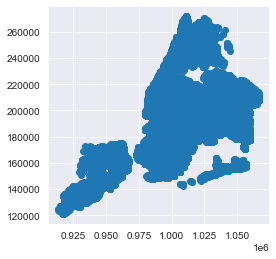

In [14]:
# sanity check map
gdf.plot()

## Spatial Join Neighborhood Tabulation Areas (NTAs) Information to Complaints

In [15]:
# spatial join nta information to points
gdf_merged = gpd.sjoin(
    gdf,
    nta_gdf,
    how="inner",
    predicate='within'
)

# drop right index column and reset gdf index
gdf_merged = (
    gdf_merged
    .drop(columns=['index_right'])
    .reset_index(drop=True)
)

# sanity checks
print('shape of data: {:,}'.format(gdf_merged.shape[0]))
print('count dropped rows: {}'.format(gdf.shape[0] - gdf_merged.shape[0]))
print('unique_key unique: {}.'.format(gdf_merged['unique_key'].is_unique))
print('crs: {}'.format(gdf_merged.crs))

# preview data
gdf_merged.head()

TypeError: sjoin() got an unexpected keyword argument 'predicate'

In [ ]:
# summary of gdf
gdf_merged.info()

In [ ]:
# examine two borough columns, check borough comparison between complaint and nta
condition = (gdf_merged['borough'].str.title() != gdf_merged['boro_name'].str.title())
count = gdf_merged.loc[condition].shape[0]

print("count of borough names that don't reconcile: {:,}".format(count))

In [ ]:
# drop borough column from 311 dataset, using this pandas style so we can run this cell again if needed
criteria = gdf_merged.columns.isin(['borough'])
gdf_merged = gdf_merged.loc[:, gdf_merged.columns[~criteria]]

print('shape of data: {}\n'.format(gdf_merged.shape))
gdf_merged.info()

# Mapping

## Hexbin Maps of Counts of Complaints

In [ ]:
# identify max bounds of hexbin gridsize=30
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
)

plt.close()
print('max value of array: {}'.format(hb.get_array().max()))

In [ ]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 50, 150, 250, 350, 450], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

label = "Count of NYC 311 Street Flooding Complaints from 2010 to 2020"
ax.set_title(label, fontsize=13)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [ ]:
# identify max bounds of hexbin gridsize=50
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
)

plt.close()
print('max value of array: {}'.format(hb.get_array().max()))

In [ ]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

label = "Count of NYC 311 Street Flooding Complaints from 2010 to 2020"
ax.set_title(label, fontsize=13)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

### Counts By Borough

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Queens'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boro_name'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Count of 311 Street Flooding Complaints from 2010 to 2020 in Queens, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Brooklyn'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boro_name'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)
 
label = 'Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Brooklyn, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Bronx'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'x_coordinate_state_plane'],
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boro_name'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in The Bronx, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Manhattan'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Manhattan, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Staten Island'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boro_name'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)


label = 'Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Staten Island, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

## Counts by Neighborhood Tabulation Areas (NTA)

In [ ]:
# group complaints by NTA
grouped_gdf = (
    gdf_merged
    .groupby(by='ntaname_boro')['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

# merge nta complaint counts with nta shapefile
nta_gdf_counts = nta_gdf.merge(
    grouped_gdf,
    on='ntaname_boro'
)

# get count per sq mi
area = nta_gdf_counts['shape_area_sq_mi'].replace(0, np.nan)
nta_gdf_counts['count_sq_mi'] = round(nta_gdf_counts['count'] / area, 2)

print('shape of data: {}\n'.format(nta_gdf_counts.shape))
nta_gdf_counts.head()

In [ ]:
# summary stats of nta counts
nta_gdf_counts.loc[:, ['count', 'count_sq_mi']].describe()

In [ ]:
# preview count sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

**Table xx:** Highest Count of 311 Street Flooding Complaints by Neighborhood Tabulation Area (NTA) in New York City.

In [ ]:
# preview count_sq_mi sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count_sq_mi', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

**Table xx:** Highest Count of 311 Street Flooding Complaints per Square Mile by Neighborhood Tabulation Area (NTA) in New York City.

In [ ]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints by NTA from 2010-2020'
plt.title(label, fontsize=12, pad=10, x=.1)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)

plt.tight_layout()

**Figure xx:**

In [ ]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count_sq_mi', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count_sq_mi',
    color='#1f77b4'
)

label = 'Count of NYC 311 Street Flooding Complaints Per Square Mile by NTA from 2010-2020'
plt.title(label, fontsize=12, pad=10, x=.1)
plt.xlabel('Count per Square Mile', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)

plt.tight_layout()

**Figure xx:**

In [ ]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 7))

# first plot
data = nta_gdf_counts.sort_values(by='count', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints\n\
by Neighborhood Tabulation Area (NTA) from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10, x=.4)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('')

# second plot
data = nta_gdf_counts.sort_values(by='count_sq_mi', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count_sq_mi',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints Per Square Mile\n\
by Neighborhood Tabulation Area (NTA) from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10, x=.38)
axs[1].set_xlabel('Count per Square Mile', fontsize=12)
axs[1].set_ylabel('')

fig.tight_layout()
plt.savefig('figures/counts-nta.png', dpi=250, bbox_inches='tight')

**Figure xx:**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

nta_gdf_counts.plot(
    column='count_sq_mi', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax,
    zorder=1
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax,
    zorder=2
)

title = 'Count of NYC 311 Street Flooding Complaints per Square Mile\n\
by Neighborhood Tabulation Area (NTA) from 2010 to 2020'
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png', bbox_inches='tight', dpi=250)

**Figure xx:**

## Counts by Neighborhood Tabulation Areas (NTA) and Year

In [ ]:
year_nta = (
    gdf_merged
    .groupby(by=['year', 'ntaname_boro'])['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

year_nta = nta_gdf.merge(
    year_nta, 
    on='ntaname_boro',
    how='left'
)

year_nta = (
    year_nta
    .loc[~year_nta['year'].isnull()]
    .astype({'year':'int'})
    .reset_index(drop=True)
)

year_nta['count'] = year_nta['count'].fillna(0).astype(int)
year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area_sq_mi']).replace(0, np.nan)).round(2)

print('shape of data: {}\n'.format(year_nta.shape))
year_nta.head()

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))

for ax, year in zip(axes.flat, year_nta['year'].unique()):
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    (year_nta
     .loc[year_nta['year'] == year]
     .plot(
         column='count_sq_mi', 
         cmap='Blues',
         legend=True,
         ax=ax, 
         cax=cax)
    )
    
    nta_gdf.plot(
        facecolor="none",
        edgecolor="black",
        linewidth=.09,
        ax=ax
    )
    
    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,2].set_axis_off()
axes[2,3].set_axis_off()

label = 'Count of NYC 311 Street Flooding Complaints Per Square Mile\n\
by Neighborhood Tabulation Area (NTA) and Year'
fig.suptitle(label, y=.96, fontsize=13) 

fig.tight_layout()   

**Figure xx:**


## Timedelta of Complaints Response Time

In [ ]:
# calculate complaint close out duration
gdf_merged['complaint_duration'] = gdf_merged['closed_date'] - gdf_merged['created_date']

gdf_merged.loc[:, ['created_date', 'closed_date', 'complaint_duration']].head(10)

In [ ]:
# retrieve dt values
gdf_merged['complaint_duration_days'] = gdf_merged['complaint_duration'].dt.days
gdf_merged['complaint_duration_seconds'] = gdf_merged['complaint_duration'].dt.seconds
gdf_merged['complaint_duration_hours'] = gdf_merged['complaint_duration'] / pd.Timedelta(hours=1)

# examine distribution of complaint duration
cols = ['complaint_duration', 'complaint_duration_days', 'complaint_duration_hours']
gdf_merged.loc[:, cols].describe()

In [ ]:
# calculate median complaint close out duration 
grouped_gdf = (
    gdf_merged
    .groupby('ntaname_boro')['complaint_duration_hours']
    .median()
    .reset_index()
)

# merge to geodataframe to plot
nta_shape_time = nta_gdf.merge(
    grouped_gdf, 
    left_on='ntaname_boro', 
    right_on='ntaname_boro'
)

nta_shape_time.head()

In [ ]:
# examine value distributions
nta_shape_time.loc[:, ['complaint_duration_hours']].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 6, 12, 18, 24, 36], cmap.N)

nta_shape_time.plot(
    column='complaint_duration_hours', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

title = 'Median Response Hours for NYC 311 Street Flooding Complaints by NTA'
ax.set_title(title, fontsize=13, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**